In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU, Add
from keras.layers import Conv1D, Flatten, BatchNormalization, LocallyConnected1D 
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# load the US8K dataset
features = np.load('./drive/MyDrive/dataset_US.npy',allow_pickle= True)
# load the data labels from the metadata file 
df = pd.read_csv('./drive/MyDrive/UrbanSound8K.csv', usecols=['classID'], dtype={'classID': np.int32})
data_class = df.to_numpy().flatten()
# split the data into testset and trainset
X_train, X_test, y_train, y_test = train_test_split(features, data_class, test_size=0.1, random_state=75)
# reshape the data 
x_tr = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_ts = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [3]:
# describe the neural network
def ConvBlock(inputs, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    return x

def LocalBlock(inputs, filters, kernel_size):
    x = LocallyConnected1D(filters, kernel_size)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.05)(x)
    return x

def DenseBlock(inputs, neuron_count):
    x = Dense(neuron_count)(inputs)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(0.5)(x)
    return x

# specify the NN's input
f_inp = Input(shape=(features.shape[1],1))

# define four parallel streams for feature extraction
x_0 = ConvBlock(f_inp, 64, 3)
x_0 = LocalBlock(x_0, 16, 3)

x_1 = ConvBlock(f_inp, 64, 7)
x_1 = LocalBlock(x_1, 16, 3)

x_2 = ConvBlock(f_inp, 64, 11)
x_2 = LocalBlock(x_2, 16, 3)

x_3 = ConvBlock(f_inp, 64, 17)
x_3 = LocalBlock(x_3, 16, 3)

x_4 = ConvBlock(f_inp, 64, 23)
x_4 = LocalBlock(x_4, 16, 3)

# merge the streams via addition
x = Add()([x_0, x_1, x_2, x_3, x_4])

# extract the final feature map
x = LocalBlock(x, 32, 3)

# flatten the feature map           
x = Flatten()(x)

# classify the data
x = DenseBlock(x, 200)
x_out = Dense(10, activation='softmax')(x)

In [6]:
# NN instantiation
model = Model(inputs=f_inp, outputs=x_out)

# load model weights  
model.load_weights('./model')

# test the NN
pred = model.predict(x_ts)
pred_y = pred.argmax(axis=-1)

# report the classification accuracy
print(f"accuracy = {accuracy_score(y_test, pred_y)}")

28/28 [==============================] - 56s 48ms/step
accuracy = 0.9805491990846682


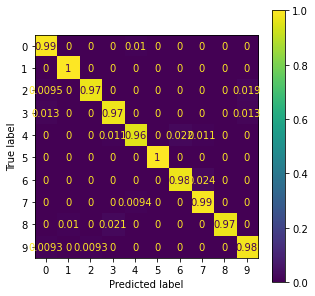

In [7]:
# display the confusion matrix
con_matrix = confusion_matrix(y_test, pred_y)
cmn = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
cmd = ConfusionMatrixDisplay(confusion_matrix=cmn)
cmd.plot(ax=ax)
# save the confusion matrix
plt.savefig("cm.png", format='png', dpi=600, bbox_inches='tight')